<a href="https://colab.research.google.com/github/milo24k/alcf-AI-ScienceTraining/blob/main/Copy_of_01_introduction_mnist_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Neural Networks
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="images/mnist_task.png"  align="left"/>



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 123MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 40.2MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 104MB/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.84MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

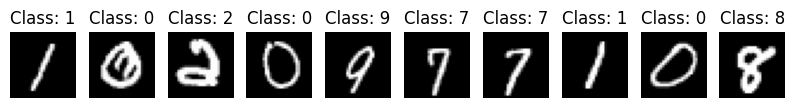

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week.
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication.

Note, like before, we consider multiple examples at once, adding another dimension to the input.


 <img src="images/LinearModel_1.png"  align="center"/>



The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step.

In [6]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [7]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [8]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [11]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5020274708271026, accuracy: 87.50625
Epoch 0: val. loss: 0.49462129017140005, val. accuracy: 87.675
Epoch 1: training loss: 0.42169949118296307, accuracy: 88.97083333333333
Epoch 1: val. loss: 0.41258433175847886, val. accuracy: 88.90833333333333
Epoch 2: training loss: 0.3877723075548808, accuracy: 89.63125
Epoch 2: val. loss: 0.3780300284319736, val. accuracy: 89.43333333333334
Epoch 3: training loss: 0.3678260585467021, accuracy: 90.075
Epoch 3: val. loss: 0.3578656311047838, val. accuracy: 89.95
Epoch 4: training loss: 0.35425476864973704, accuracy: 90.38333333333334
Epoch 4: val. loss: 0.3442709815311939, val. accuracy: 90.24166666666666
CPU times: user 1min 10s, sys: 287 ms, total: 1min 10s
Wall time: 1min 11s


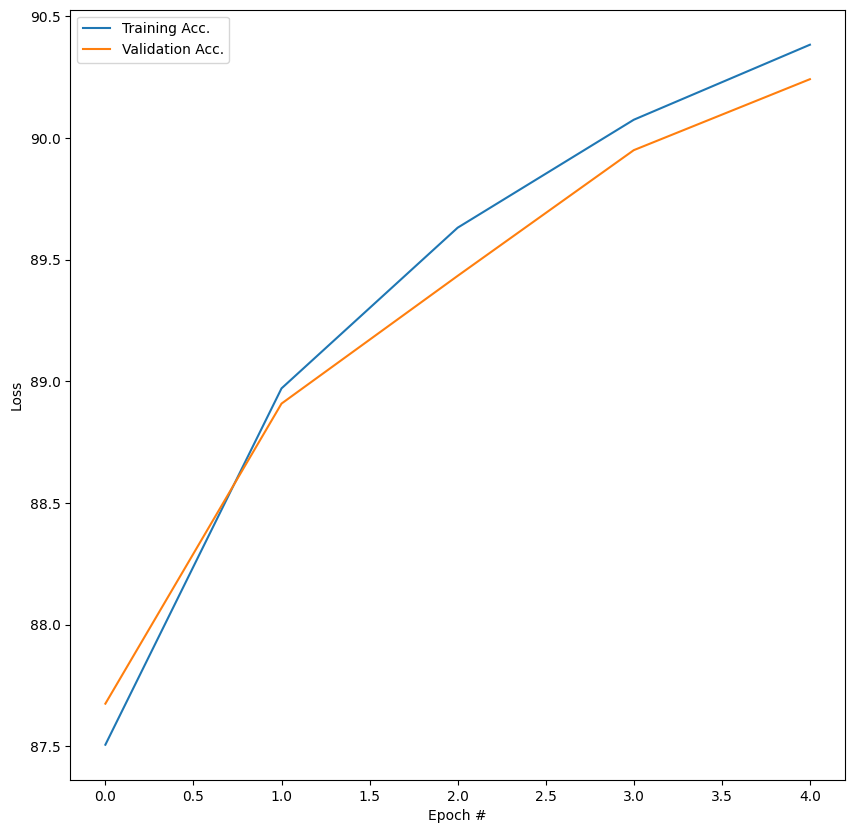

In [12]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

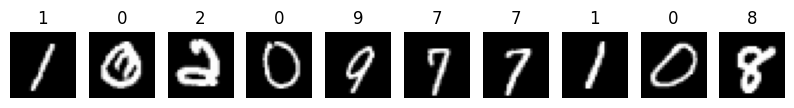

In [13]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Prediction

Let's see how our model generalizes to the unseen test data.



In [14]:
#For HW: cell to change batch size
#create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [15]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3323, test accuracy: 90.86%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [16]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


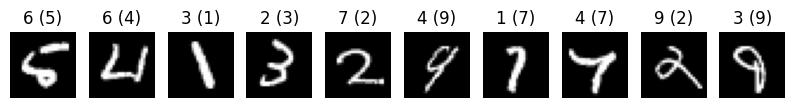

In [17]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="images/shallow_nn.png"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="images/activation.jpeg"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="images/deep_nn_annotated.jpg"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="images/bias_vs_variance.png"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="images/acc_under_over.webp"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [18]:
#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [19]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [20]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.6936821632385254, accuracy: 79.86041666666667
Epoch 0: val. loss: 0.6873343840558478, val. accuracy: 79.54166666666667
Epoch 1: training loss: 0.3821901308695475, accuracy: 89.22708333333334
Epoch 1: val. loss: 0.37148728554553173, val. accuracy: 89.25833333333333
Epoch 2: training loss: 0.2931054387887319, accuracy: 91.6875
Epoch 2: val. loss: 0.28391945013340486, val. accuracy: 91.53333333333333
Epoch 3: training loss: 0.2448734374642372, accuracy: 92.85208333333334
Epoch 3: val. loss: 0.23948240296003667, val. accuracy: 92.72500000000001
Epoch 4: training loss: 0.20254576470454533, accuracy: 94.20625
Epoch 4: val. loss: 0.2019459550526548, val. accuracy: 94.0
CPU times: user 1min 11s, sys: 190 ms, total: 1min 11s
Wall time: 1min 12s


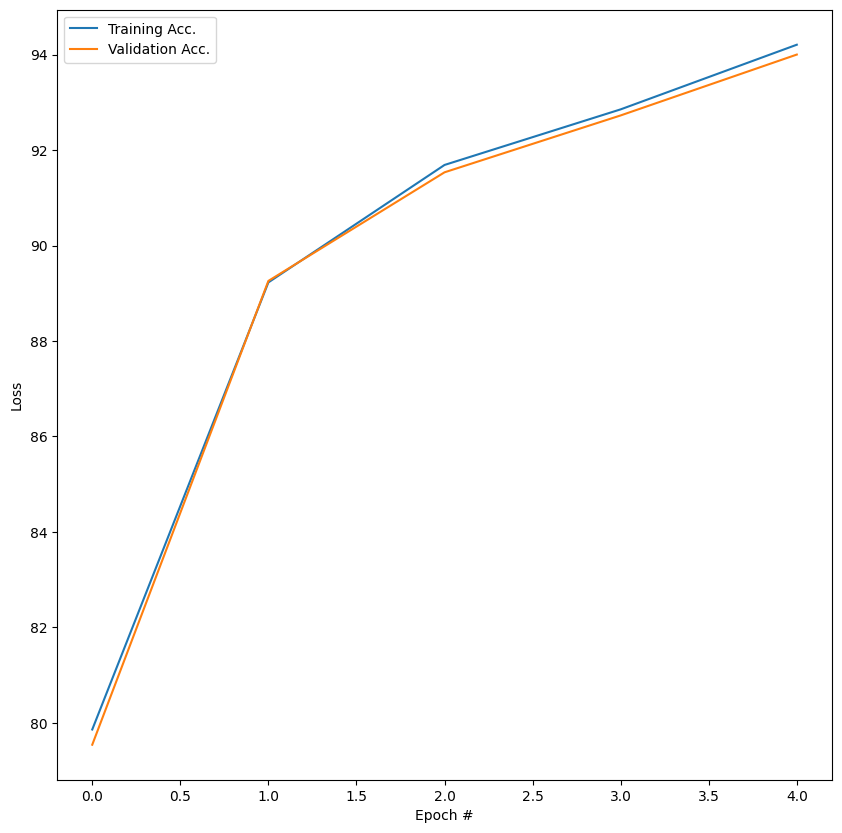

In [21]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


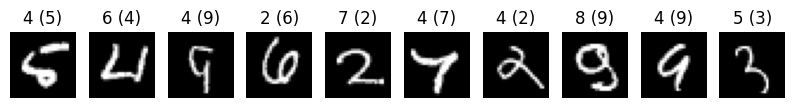

In [22]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

# **Homework Solution:**

# A. Model quality comparison using:
 a. Different batch size.


 b. Different learning rates.

 c. Different activation functions.

# **a. Different batch size**
We will test a batch size to 32.
As for activation functions, we are using ReLU, Sigmoid, and also Tanh. For learning rate we use 0.001.

In [23]:
batch_size = 32

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [24]:
#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x



In [25]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.001)

In [26]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 2.300080842812856, accuracy: 11.2375
Epoch 0: val. loss: 2.2996735134124755, val. accuracy: 11.233333333333333
Epoch 1: training loss: 2.297909793059031, accuracy: 11.2375
Epoch 1: val. loss: 2.297533362706502, val. accuracy: 11.233333333333333
Epoch 2: training loss: 2.2958896107673645, accuracy: 11.2375
Epoch 2: val. loss: 2.2955294310251873, val. accuracy: 11.233333333333333
Epoch 3: training loss: 2.2934958054224652, accuracy: 11.2375
Epoch 3: val. loss: 2.293134209950765, val. accuracy: 11.233333333333333
Epoch 4: training loss: 2.290511188666026, accuracy: 11.2375
Epoch 4: val. loss: 2.2901348298390705, val. accuracy: 11.233333333333333
CPU times: user 1min 29s, sys: 274 ms, total: 1min 30s
Wall time: 1min 32s


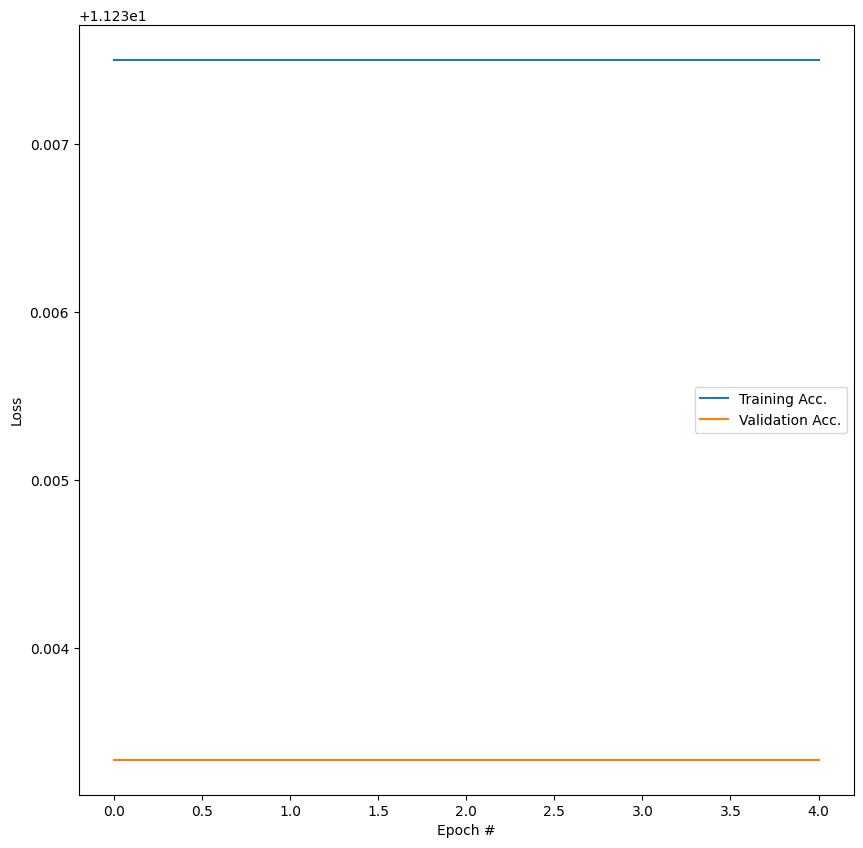

In [27]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Overall the quality of the answer (accuracy) is worsened as well as time to run is increased significatively.

# **b. Different learning rates**
We will continue the use of a batch size of 32.
As for activation functions, we are using ReLU, Sigmoid, and also Tanh. For learning rate we use 0.001.

In [28]:
def train_and_evaluate_with_lr(learning_rates, epochs, train_dataloader, val_dataloader, model_class, loss_fn_class, batch_size):
    results = {}
    for lr in learning_rates:
        # Initialize the model, loss function, and optimizer for each learning rate
        model = model_class()
        loss_fn = loss_fn_class()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        print(f"\nTraining with learning rate: {lr}")
        train_acc_all = []
        val_acc_all = []

        for j in range(epochs):
            train_one_epoch(train_dataloader, model, loss_fn, optimizer)

            # checking on the training loss and accuracy once per epoch
            train_acc, train_loss = evaluate(train_dataloader, model, loss_fn)
            train_acc_all.append(train_acc)
            print(f"Epoch {j}: training loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")

             # checking on the validation loss and accuracy once per epoch
            val_acc, val_loss = evaluate(val_dataloader, model, loss_fn)
            val_acc_all.append(val_acc)
            print(f"Epoch {j}: validation loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")

        # Save results for this learning rate
        results[lr] = {
            "train_accuracy": train_acc_all,
            "validation_accuracy": val_acc_all
        }

    return results

In [29]:
learning_rates = [0.01, 0.03, 0.05, 0.06, 0.1]

epochs = 5

results = train_and_evaluate_with_lr(
    learning_rates=learning_rates,
    epochs=epochs,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    model_class=NonlinearClassifier,
    loss_fn_class=nn.CrossEntropyLoss,
    batch_size=batch_size
)



Training with learning rate: 0.01
Epoch 0: training loss: 2.2512, accuracy: 31.8479
Epoch 0: validation loss: 2.2508, accuracy: 32.6167
Epoch 1: training loss: 1.5746, accuracy: 50.4563
Epoch 1: validation loss: 1.5698, accuracy: 51.1917
Epoch 2: training loss: 0.9243, accuracy: 71.9708
Epoch 2: validation loss: 0.9226, accuracy: 71.5250
Epoch 3: training loss: 0.6082, accuracy: 84.0688
Epoch 3: validation loss: 0.6074, accuracy: 83.6333
Epoch 4: training loss: 0.4598, accuracy: 87.7375
Epoch 4: validation loss: 0.4571, accuracy: 87.6417

Training with learning rate: 0.03
Epoch 0: training loss: 0.8509, accuracy: 75.4688
Epoch 0: validation loss: 0.8515, accuracy: 75.1417
Epoch 1: training loss: 0.4459, accuracy: 88.0000
Epoch 1: validation loss: 0.4389, accuracy: 88.0250
Epoch 2: training loss: 0.3192, accuracy: 91.2604
Epoch 2: validation loss: 0.3154, accuracy: 90.8500
Epoch 3: training loss: 0.2540, accuracy: 92.9771
Epoch 3: validation loss: 0.2537, accuracy: 92.7083
Epoch 4: tra

Out of the learning rates used, the best accuracy results were obtained when using learning rate 0.05 and 0.1 (being 0.05 learning rate the best option also if it's small).

# **a.** and **b.** Combination test: Test using different learning rates and different batch sizes

In [30]:
import torch
from torch import nn
from torch.utils.data import DataLoader

def train_model_with_params(training_data, validation_data, test_data, batch_sizes, learning_rates, epochs=5):
    results = []

    class NonlinearClassifier(nn.Module):
        def __init__(self):
            super().__init__()
            self.flatten = nn.Flatten()
            self.layers_stack = nn.Sequential(
                nn.Linear(28*28, 50),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(50, 50),
                nn.ReLU(),
                nn.Linear(50, 50),
                nn.ReLU(),
                nn.Linear(50, 10)
            )

        def forward(self, x):
            x = self.flatten(x)
            return self.layers_stack(x)

    for batch_size in batch_sizes:
        # Set up the dataloaders for each batch size
        train_dataloader = DataLoader(training_data, batch_size=batch_size)
        val_dataloader = DataLoader(validation_data, batch_size=batch_size)
        test_dataloader = DataLoader(test_data, batch_size=batch_size)

        for lr in learning_rates:
            # Initialize model and optimizer with current learning rate
            model = NonlinearClassifier()
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)

            train_acc_all = []
            val_acc_all = []

            # Training loop
            for epoch in range(epochs):
                train_one_epoch(train_dataloader, model, loss_fn, optimizer)
                train_acc, train_loss = evaluate(train_dataloader, model, loss_fn)
                train_acc_all.append(train_acc)

                val_acc, val_loss = evaluate(val_dataloader, model, loss_fn)
                val_acc_all.append(val_acc)

                print(f"Batch size: {batch_size}, Learning Rate: {lr}, Epoch {epoch}: Training loss: {train_loss}, Training accuracy: {train_acc}, Val loss: {val_loss}, Val accuracy: {val_acc}")

            results.append({
                'batch_size': batch_size,
                'learning_rate': lr,
                'train_accuracy': train_acc_all,
                'val_accuracy': val_acc_all
            })

    return results


In [31]:
batch_sizes = [64, 128, 256]
learning_rates = [0.01, 0.05, 0.1]
results = train_model_with_params(training_data, validation_data, test_data, batch_sizes, learning_rates)


Batch size: 64, Learning Rate: 0.01, Epoch 0: Training loss: 2.1661773522694907, Training accuracy: 29.379166666666666, Val loss: 2.165149244856327, Val accuracy: 29.56666666666667
Batch size: 64, Learning Rate: 0.01, Epoch 1: Training loss: 1.2239323349793751, Training accuracy: 66.02291666666666, Val loss: 1.219989224317226, Val accuracy: 65.41666666666667
Batch size: 64, Learning Rate: 0.01, Epoch 2: Training loss: 0.62247263499101, Training accuracy: 82.05, Val loss: 0.6112006996223267, Val accuracy: 82.15833333333333
Batch size: 64, Learning Rate: 0.01, Epoch 3: Training loss: 0.47733929560581845, Training accuracy: 86.22916666666667, Val loss: 0.46748093904015864, Val accuracy: 86.04166666666667
Batch size: 64, Learning Rate: 0.01, Epoch 4: Training loss: 0.4021182517608007, Training accuracy: 88.62291666666667, Val loss: 0.3931770489570942, Val accuracy: 88.29166666666667
Batch size: 64, Learning Rate: 0.05, Epoch 0: Training loss: 0.3819501982132594, Training accuracy: 88.94375

While individual parameters modifications can give us better or worse results, given their correlation it's important to consider that in order to obtain the best results, it's needed to modify not only batch size but also learning rate and function in conjuction. In this example we observed that the modification of the learning rate and also the batch size gave us the best result while using a batch size of 128 and learning rate of 0.1.

We can observe that the best Validation Accuracy is reach at the batch size 128 and the learning rate 0.1. Now, we will just work with the batch size 128 and the leanring rate 0.1 and we will explore the model performance changing just the activation functions. We tried three different models, one with ReLU, Sigmoid, Tanh, other model using just Sigmoid and ReLU, and the last one using Tanh and ReLU.



# **c. Different activation functions**

# a. Now that we observed the result modifying batch size and also learning rate, now we also be testing with different activation functions to find the best possible result (we will use 128 batch size and a learning rate of 0.1) We will use a model with Sigmoid, ReLU, and Tanh Activations functions.

Epoch 0: training loss: 1.2813312005996704, accuracy: 59.66666666666667
Epoch 0: val. loss: 1.2760276096932432, val. accuracy: 59.88333333333333
Epoch 1: training loss: 0.5261834740638733, accuracy: 85.71041666666666
Epoch 1: val. loss: 0.5169378091046151, val. accuracy: 85.75
Epoch 2: training loss: 0.3683925493955612, accuracy: 89.89166666666667
Epoch 2: val. loss: 0.3631065965015837, val. accuracy: 89.525
Epoch 3: training loss: 0.28828339608510334, accuracy: 92.03333333333333
Epoch 3: val. loss: 0.28508156712384936, val. accuracy: 91.66666666666666
Epoch 4: training loss: 0.23086820260683696, accuracy: 93.62083333333334
Epoch 4: val. loss: 0.23033672935785132, val. accuracy: 93.48333333333333


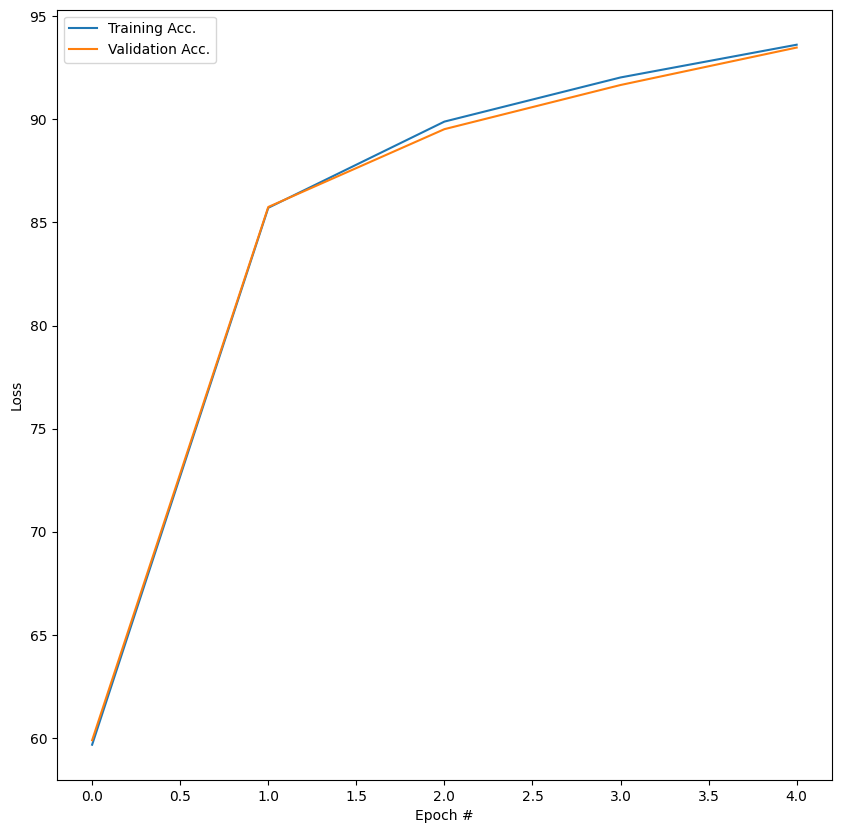

In [32]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)


epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

This model provided somewhat better answers that the one used during the class.

# b. We will use 128 batch size and a learning rate of 0.1. The model will be with with two layers of Sigmoid, and one layer with ReLU activations function.

Epoch 0: training loss: 2.296981938680013, accuracy: 11.245833333333334
Epoch 0: val. loss: 2.297202650536882, val. accuracy: 11.241666666666667
Epoch 1: training loss: 2.1700327994028727, accuracy: 23.5125
Epoch 1: val. loss: 2.1703461307160397, val. accuracy: 23.575
Epoch 2: training loss: 1.7205984309514364, accuracy: 41.49375
Epoch 2: val. loss: 1.7195159120762602, val. accuracy: 41.56666666666667
Epoch 3: training loss: 1.0913812055587768, accuracy: 67.20833333333334
Epoch 3: val. loss: 1.0891638017715293, val. accuracy: 67.60833333333333
Epoch 4: training loss: 0.7764078237215678, accuracy: 76.32291666666666
Epoch 4: val. loss: 0.7778457010045965, val. accuracy: 75.925


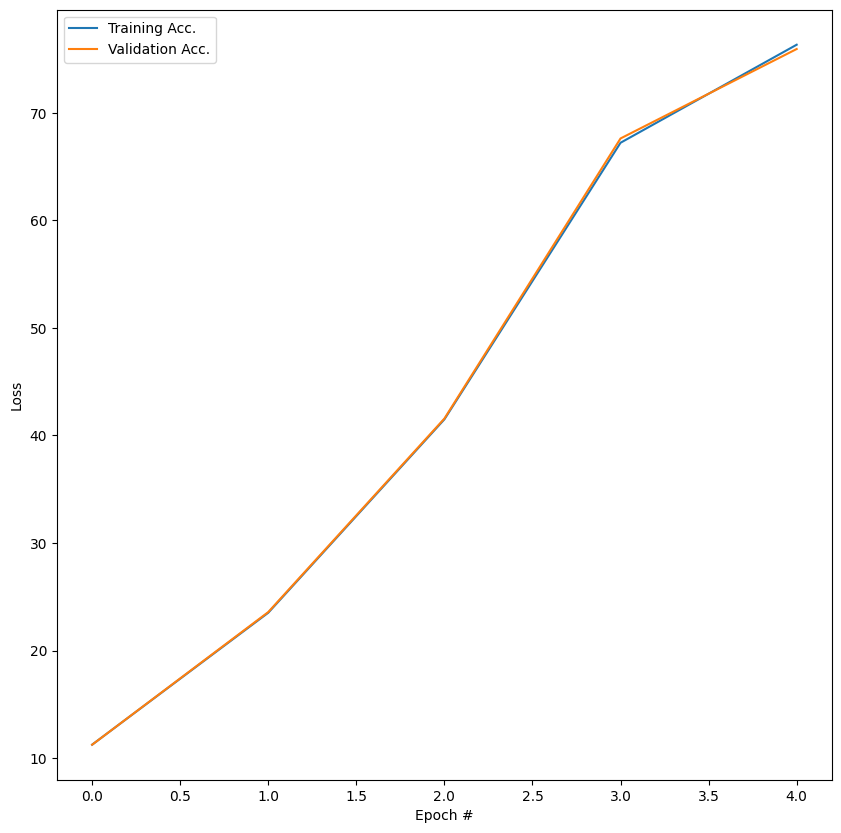

In [33]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)


epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

This model accuracy decreased due to our use of two layers of Sigmoid and one of ReLU.

# c. We will use 128 batch size and a learning rate of 0.1. The model will be with two layers with Tanh, and one layer with ReLU activation functions.

Epoch 0: training loss: 0.37600731281439465, accuracy: 89.68333333333334
Epoch 0: val. loss: 0.3717704730782103, val. accuracy: 89.33333333333333
Epoch 1: training loss: 0.2311372147401174, accuracy: 93.45208333333333
Epoch 1: val. loss: 0.22904428134256222, val. accuracy: 93.2
Epoch 2: training loss: 0.18640961901346842, accuracy: 94.58333333333333
Epoch 2: val. loss: 0.19119646550810082, val. accuracy: 94.26666666666667
Epoch 3: training loss: 0.14938903594017028, accuracy: 95.62916666666666
Epoch 3: val. loss: 0.1575469747185707, val. accuracy: 95.275
Epoch 4: training loss: 0.12859906553228695, accuracy: 96.26666666666667
Epoch 4: val. loss: 0.14178781873209678, val. accuracy: 95.65


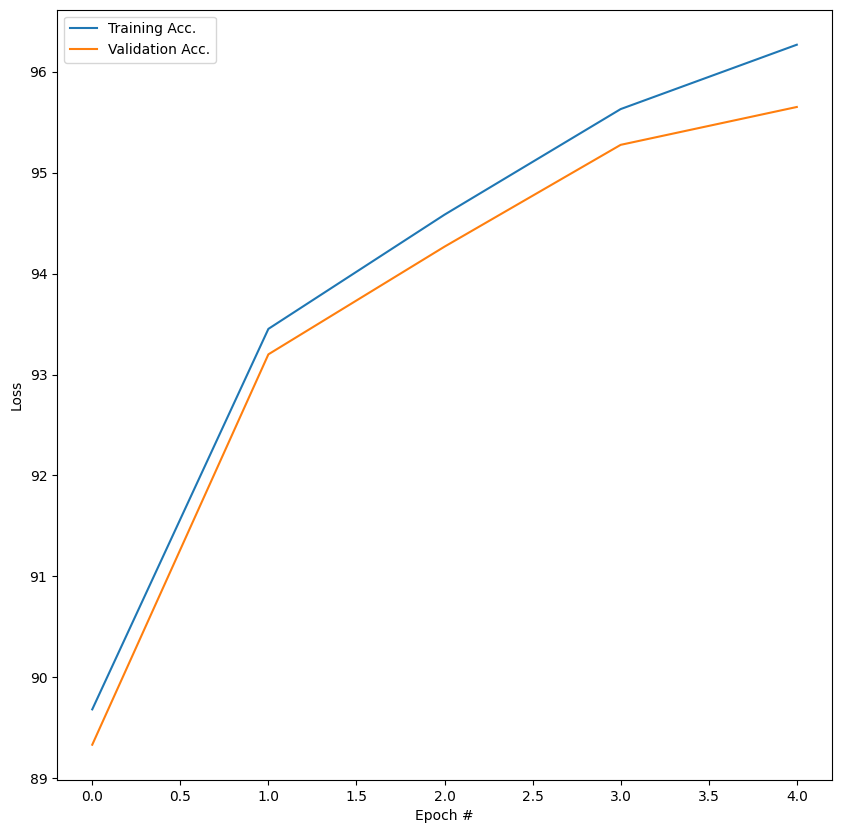

In [34]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)


epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

 As observed above, we see that there is a tendency of better validation accuracy while using Tanh activation function.

# Bonus: What is a learning rate scheduler?


It is a predefined framework which adjusts learning rate as the training progresses. This adjustment happends between epochs or iterations. There are 2 main learning techniques: constant learning and learning decay.  

* Constant learning is kept as it is during the learning and does not change.
* For Learning decay, we select a learning rate and then we gradually reduce it according to the scheduler.

Adjusting the model and being able to see how these modifications affect the outcome is important to evaluate their weight in the model and the way in which we can reach a higher accuracy leveraging a small learning rate.